### パッケージのインポート

In [1]:
import csv
import os
import random
from datetime import datetime as dt

import matplotlib.pyplot as plt
import pandas as pd

### データの変換と確認

#### 関数の定義

In [2]:
# 水位テキストデータのcsvファイルへの変換
def txt_csv_converter(filename, writer):
    with open(filename, encoding="shift-jis") as f:
        file = f.readlines()
        for row in file:
            if row[0:4] != "2011":
                continue
            read = []
            read.append(row[0:8])
            read.append(row[9:15])

            if row[17:24] == "9999.99":
                read.append(None)
            else:
                read.append(float(row[17:24]))
            
            if row[26:33] == "9999.99":
                read.append(None)
            else:
                read.append(float(row[26:33]))
            
            if row[35] == "9":
                read.append(None)
            else:
                read.append(float(row[35:42]))

            writer.writerow(read)


# ファイル名のリスト取得
def get_file_data(dir_path) -> list:
    filenames = sorted(os.listdir(dir_path))
    if ".DS_Store" in filenames:
        filenames.remove(".DS_Store")
    return filenames


# 日時情報の一元化、切り取り
def df_create(filename) -> pd.DataFrame:
    df = pd.read_csv(filename, 
                     names=["date", "time", "observed", "astoro", "deviation"])

    df["date"] = df["date"].astype(str)
    df["time"] = df["time"].astype(str)

    for i in range(len(df)):
        df.loc[i, "time"] = df.loc[i, "time"].zfill(6)
        s = df.loc[i, "date"] + df.loc[i, "time"]
        df.loc[i, "datetime"] = dt.strptime(s, "%Y%m%d%H%M%S")
    df = df.drop(["date", "time"], axis=1)

    start = df[df["datetime"] == dt(2011,3,11,14,30,00)].index[0]
    end = df[df["datetime"] == dt(2011,3,12,00,00,00)].index[0]

    cut_df = df.iloc[start:end].reset_index()
    return cut_df


# 欠損値数の確認
def null_cnt(dir_path, filenames) -> list:
    list = []
    for filename in filenames:
        cut_df = df_create(dir_path+"/csv/"+filename)

        list += [[filename, cut_df.isnull().any(axis=1).sum()]]

    return list


#### データの変換

In [3]:
# 各データをcsvファイルに変換
filename_path = "../data/tsunami/NOWPHAS_Tsunami_data"
filenames = get_file_data(filename_path+"/raw")

for filename in filenames:
    csv_file = filename_path + "/csv/" + filename[:11] + ".csv"
    with open(csv_file, mode="w", newline="") as fw:
        writer = csv.writer(fw, delimiter=",")
        txt_csv_converter(filename_path+"/raw/"+filename, writer)

#### メインデータの確認

In [4]:
# 各データの欠損値数の確認
csv_filenames = get_file_data(filename_path+"/csv")
null_list = null_cnt(filename_path, csv_filenames)

null_df = pd.DataFrame(null_list, columns=["filename", "null_num"])
null_df = null_df[null_df["null_num"] > 0].sort_values("null_num", ascending=False)
null_df

,filename,null_num
7,2011TET219W.csv,6135
6,2011TET219T.csv,6057
3,2011TET203W.csv,5915
4,2011TET205W.csv,5874
2,2011TET203T.csv,4583
42,2011TET901T.csv,1080
14,2011TET316T.csv,299
39,2011TET812G.csv,44
36,2011TET806G.csv,36
35,2011TET804G.csv,29


/var/folders/yy/h4ndzppd11l1g6sl_d1_jymw0000gq/T/ipykernel_70861/2669542479.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


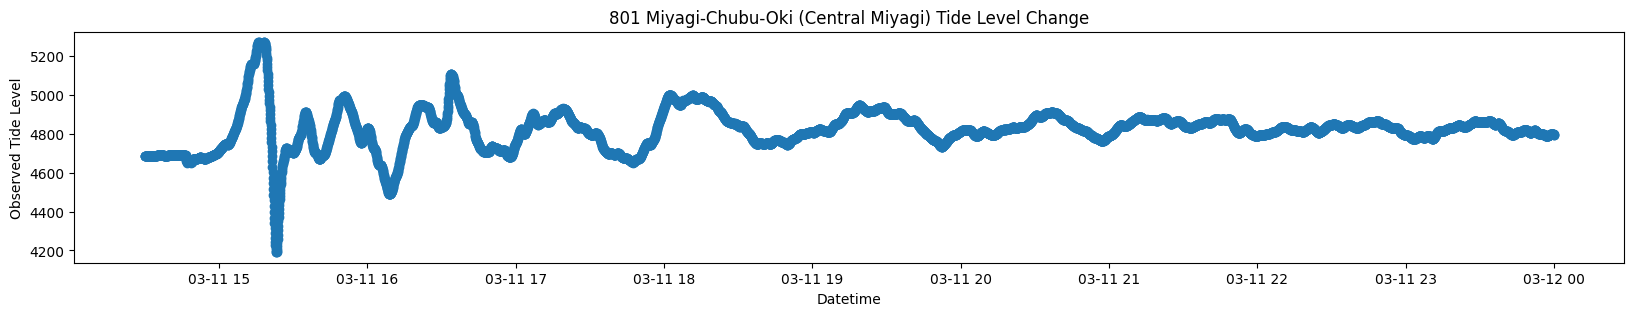

In [5]:
# 実測水位データの可視化
fig = plt.figure(figsize=(20,3))

cut_test_df = df_create(filename_path+"/csv/2011TET801G.csv")
plt.scatter(x=cut_test_df["datetime"], y=cut_test_df["observed"])
plt.title("801 Miyagi-Chubu-Oki (Central Miyagi) Tide Level Change")
plt.xlabel("Datetime")
plt.ylabel("Observed Tide Level")

fig.show()

#### 欠損値補完

In [6]:
# 欠損値補完
def completion(df:pd.DataFrame, nan_num, seed_val):
    random.seed(seed_val)
    nan_index = sorted(random.sample(range(1, len(df)-1), nan_num))

    nan_full_df = df.copy()
    for idx in nan_index:
        nan_full_df.loc[idx, "observed"] = float("nan")
    filled_df = nan_full_df.copy()

    for i in range(nan_num):
        if i != nan_num-1 and nan_index[i]+1 == nan_index[i+1]:
            filled_df.loc[nan_index[i], "observed"] = filled_df.loc[nan_index[i]-1, "observed"]
        else:
            filled_df.loc[nan_index[i], "observed"] = (filled_df.loc[nan_index[i]+1, "observed"]+
                                                    filled_df.loc[nan_index[i]-1, "observed"])/2

    return nan_full_df, filled_df, nan_index


In [7]:
# 欠損値を含むデータの確認
nan_index = []
for i in range(len(cut_test_df)):
    if cut_test_df.loc[i].hasnans:
        nan_index.append(i)

cut_test_df["datetime"].iloc[nan_index]

205   2011-03-11 14:47:05
206   2011-03-11 14:47:10
207   2011-03-11 14:47:15
208   2011-03-11 14:47:20
209   2011-03-11 14:47:25
210   2011-03-11 14:47:30
211   2011-03-11 14:47:35
212   2011-03-11 14:47:40
213   2011-03-11 14:47:45
214   2011-03-11 14:47:50
215   2011-03-11 14:47:55
216   2011-03-11 14:48:00
217   2011-03-11 14:48:05
218   2011-03-11 14:48:10
219   2011-03-11 14:48:15
220   2011-03-11 14:48:20
221   2011-03-11 14:48:25
222   2011-03-11 14:48:30
223   2011-03-11 14:48:35
224   2011-03-11 14:48:40
225   2011-03-11 14:48:45
Name: datetime, dtype: datetime64[us]

In [8]:
# フルにデータを使える部分を抽出し、ランダムに発生させた欠損値に対して補完
start = cut_test_df[cut_test_df["datetime"] == dt(2011, 3, 11, 14, 48, 50)].index[0]

full_df = cut_test_df.iloc[start:].reset_index().drop("index", axis=1)
nan_test_df, completion_test_df, nan_index = completion(full_df, 3, seed_val=42)

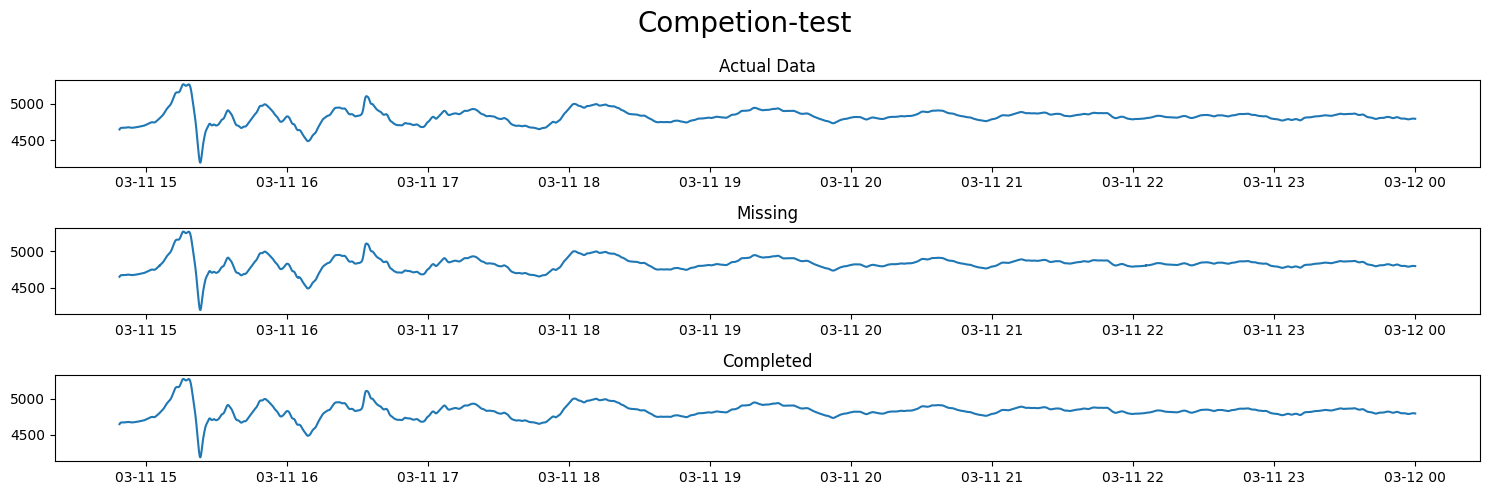

205    2011-03-11 15:05:55
913    2011-03-11 16:04:55
5239   2011-03-11 22:05:25
Name: datetime, dtype: datetime64[us]

In [9]:
#グラフを表示
fig, ax = plt.subplots(3,figsize=(15,5))

ax[0].plot(full_df["datetime"], full_df["observed"])
ax[0].set_title("Actual Data")

ax[1].plot(nan_test_df["datetime"], nan_test_df["observed"])
ax[1].set_title("Missing")

ax[2].plot(completion_test_df["datetime"], completion_test_df["observed"])
ax[2].set_title("Completed")

plt.suptitle("Competion-test", fontsize=20)
plt.tight_layout()
plt.show()

full_df.loc[nan_index, "datetime"]

In [10]:
# 補完方法の評価
num = 100
runs = 10**3

error = 0
for i in range(runs):
    nan_full_df, filled_df, nan_index = completion(full_df, num, seed_val=i)
    for idx in nan_index:
        error += abs(full_df.loc[idx, "observed"] - filled_df.loc[idx, "observed"])

# 平均絶対誤差に変換して出力
print(f"平均絶対誤差 :\n\terror : {error / (num * runs)}")

平均絶対誤差 :
	error : 0.12389290000000594


誤差はごく小さなものであるから,この補完方法を用いることとする.

In [11]:
# 欠損値補完
nan_full_df = cut_test_df.copy()
for idx in nan_index:
    nan_full_df.loc[idx, "observed"] = float("nan")
cmp_test_df = nan_full_df.copy()

for i in range(len(nan_index)):
    if i != len(nan_index)-1 and nan_index[i]+1 == nan_index[i+1]:
        cmp_test_df.loc[nan_index[i], "observed"] = cmp_test_df.loc[nan_index[i]-1, "observed"]
    else:
        cmp_test_df.loc[nan_index[i], "observed"] = (cmp_test_df.loc[nan_index[i]+1, "observed"]+
                                                cmp_test_df.loc[nan_index[i]-1, "observed"])/2

# 合わせて潮位偏差も補完
for i in range(len(cmp_test_df)):
    cmp_test_df.loc[i, "deviation"] = cmp_test_df.loc[i, "observed"] - cmp_test_df.loc[i, "astoro"]